# Genetic Algorithm for Optimal Path Planning

## (Random version)

In [1]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### Path class : representation of an individual

In [146]:
class Path:
    '''class to represents a path as a binary string 
    The path goes from the starting point (0,0) to the end point (n-1,n-1)
    
    Attributes:
        'n' (int) : size of the grid
        'bina' (np.array, size= 1 + (n-1)*( 2 + 1 + 1 + int(np.log(n)/np.log(2)) )) : binary representation of the path
        'occ' (np.array, shape=(n,n)) : occupancy grid ; occ[i,j] = 0 if free of obstacle, 1 otherwise

        'n_cell' (int) : number of cells crossed in the path       
        'points' ( (2D np.array) list ) : list of points on the path
        'types' (int list, len = n_cell) : types[i] = 0 if points[i] is an intermediary point of an action, 1 otherwise
        
        'pb' (np.array, size=3) : tell what are the non-valid problems of the path
        'out' (np.array, size=n) : out[i] = 1 if path out-of-bounds at step i, 0 otherwise
        'nCol' (int) : number of collisions with obstacles on the path
    
    Remarks:
        - pb[0] = 0 if path goes out of bound ;  
        - pb[1] = 0 if path doesn't end at the end point ; 
        - pb[2] = 0 if path collides with obstacles
    '''
    
    def __init__ (self, n, occ=np.zeros(0)):
        '''create a random Path instance for a grid of size n
        
        Args: 
            'n' (int) : size of the grid
            'occ' (np.array, shape=(n,n)) : occupancy grid ; occ[i,j] = 0 if free of obstacle, 1 otherwise
        '''
        self.n = n
        
        # useful to visualize paths without occupancy grid
        if occ.size == 0:
            self.occ = np.zeros((self.n, self.n))
        else:
            self.occ = occ
        
        l_code = 1 + int(np.log(n)/np.log(2))       
        self.setBina (np.random.randint(2, size = 1 + (n-1)*(3 + l_code) ) )

    def setBina (self, bina):
        self.bina = bina.copy()
        # check that the path is valid
        self.isValid()
    
    def monotone (self, axis):
        '''convert the Path into a straight line axis-monotone Path
        
        Args:
            'axis' (int, possible={0,1}) : axis of monotony
        '''
        n = self.n
        
        l_code = 1 + int(np.log(n)/np.log(2))
        bina = np.zeros(1 + (n-1)*(3 + l_code), dtype = int)
        
        bina[0] = axis
        
        for i in range(0, n-2):
            # go one cell horizontaly
            bina[1 + i*(3 + l_code):3 + i*(3 + l_code)] = [1,0]
        
        # go all the way up vertically
        bina[1 + 2 + (n-2)*(3 + l_code)] = 1
        m_pad = 1+int(np.log(n)/np.log(2)) - len(bin(n-1)[2:])
        bina[1 + 3 + (n-2)*(3 + l_code):] = np.pad(np.array([int(x) for x in bin(n-1)[2:]]), (m_pad,0), 'constant', constant_values=(0))
        
        self.setBina(bina)
    
    def inBound (self, point):
        '''check if a point from the path is inside the boundaries
        
        Args:
            'point' (int np.array, size = 2) : point from the path
            
        Returns:
            'inBound' (bool) : tells if the point from the path is inside the boundaries
        '''
        
        inBound = (point <= np.array([n-1, n-1])).all() and (point >= np.array([0, 0])).all()
        
        return inBound
    
    def buildPath (self):
        '''build the 'real world' path from the binary representation
        
        Returns:
            'types' (int list, len = n_cell) : types[i] = 0 if points[i] is an intermediary point of an action, 1 otherwise
        '''      
        n = self.n
        
        l_code = 1 + int(np.log(n)/np.log(2))
        
        # store the points on the path
        x0 = np.array([0,0])
        points = [x0]
        x_next = x0

        types = [1]
        
        # axis of monotony
        axis = self.bina[0]
        
        # each monotone path is composed of (n-1) actions
        for i in range(0, n -1):
            action = self.bina[1 + i*(3 + l_code): 1 + (i+1)*(3 + l_code)]
            # movement 
            move = action[0:2]
            
            # compute the next point
            if (move == np.array([0,0])).all(): # vertical
                x_next = x_next + np.array([1, 0])
                points.append(x_next)
                types.append(0)
                
                # direction
                sign = action[2]*2 -1
                # compute the nb of cells crossed
                n_add = action[3:].dot( 2**np.arange(action.size-3) [::-1])
                
                # compute the intermediary points
                for k in range(1, int(n_add)):
                    x_temp = x_next + k*sign*np.array([0, 1])  
                    points.append(x_temp)
                    types.append(0)
                # compute the next point
                x_next = x_next + np.array([0, sign*n_add])               
                points.append(x_next)
                                
            elif (move == np.array([0,1])).all(): # diagonal up
                x_next = x_next + np.array([1, 1])
                points.append(x_next)
            elif (move == np.array([1,0])).all(): # horizontal            
                x_next = x_next + np.array([1, 0])
                points.append(x_next)
            else: # diagonal down
                x_next = x_next + np.array([1, -1])
                points.append(x_next)
            
            types.append(1)

        self.points = np.array(points)
        self.n_cell = len(points)
        # for y-monotone : reverse x and y axis
        if axis:
            self.points = np.fliplr(self.points)
        
        self.types = types
        return types
    
    def isValid (self):
        '''tell if a Path is valid for a given grid by computing the points on the path
        
        Returns:
            'valid' (bool) : tell is the path is valid
        
        Remarks:
            - compute the points that are on the path from the binary np.array
        '''                
        n = self.n
        
        l_code = 1 + int(np.log(n)/np.log(2))
        
        types = self.buildPath()
        
        # store the types of problems
        self.pb = np.ones(3)
        self.out = np.zeros(n)
        self.nCol = 0
        
        i = 0
        # check that the path is collision free
        x_prev = np.array([0,0])
        for (j, x_next) in enumerate(self.points):
            if j == 0:
                continue
                
            i += types[j]  
            # check if x_next is within the boundaries
            test = self.inBound(x_next)

            if not test:
                self.out[i] = max(self.out[i], types[j])
                continue            
            
            # check if x_next is in an obstacle
            self.nCol += self.occ[x_next[1], x_next[0]]
        
        # check that the path stays into the boundaries
        self.pb[0] = (self.out == np.zeros((n,n))).all()
        
        # check that the path ends at the end point
        self.pb[1] = (self.points[-1] == np.array([n-1, n-1])).all()
        
        self.pb[2] = (self.nCol == 0)
        
        valid = self.pb[0] and self.pb[1] and self.pb[2]
        
        return valid
    
    def plot (self, color='blue'):
        '''plot the path on the n*n occupancy grid
        
        Args:
            'color' (String, default='blue') : color of the path plot
        '''
        
        # make a color map of fixed colors
        cmap = mpl.colors.ListedColormap(['white','black'])
        bounds=[0,0.5,1]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        # tell imshow about color map so that only set colors are used
        img = plt.imshow(self.occ, interpolation='nearest', cmap = cmap,norm=norm)

        # make a color bar
        plt.colorbar(img,cmap=cmap, norm=norm,boundaries=bounds)

        # plot the path
        plt.plot(self.points[:,0], self.points[:,1], color=color)
        

### Random Occupancy Grid generation

In [147]:
def gen_occ (n, prob = 0.3):
    '''generate random occupancy grid of size n*n
    
    Args:
        'n' (int) : size of the occupancy grid
        'prob' (double, default = 0.3) : probability of a cell being an obstacle
    
    Returns:
        'occ' (np.array, shape = (n,n)) : occupancy grid ; occ[i,j] = 0 if free of obstacle, 1 otherwise
        
    Remarks:
        - we ensure that the begin (0,0) and end (n-1,n-1) points are obstacle-free
    '''
    
    occ = (np.random.uniform(0,1, (n,n)) <= prob)
    occ[0,0] = False
    occ[n-1,n-1] = False
    #occ[n-1,:] = False
    #occ[:,n-1] = False
    
    return occ


In [156]:
occ =np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0],
               [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
               [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
               [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1],
               [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
               [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
               [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
               [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
               [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
               [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
               [1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
               [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0],
               [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0],
               [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

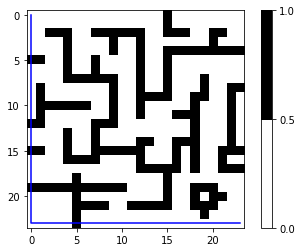

In [157]:
n = 24
path = Path(n, occ)
path.monotone(1)
path.plot()

### Random Algorithm

In [150]:
class RandomAlgorithm:
    '''class to find optimal paths on a occupancy grid via Random Algorithm
    
    Attributes:
        'occ' (np.array, shape=(n,n)) : occupancy grid ; occ[i,j] = 0 if free of obstacle, 1 otherwise
        'popu' (Path list, length=p) : current population of 'path' individuals
        'best_ind' (Path) : best individual of the population
    '''
        
    def __init__ (self, occ, p = 60):
        '''create a RandomAlgorithm instance
        
        Args:
            'occ' (np.array, shape=(n,n)) : occupancy grid ; occ[i,j] = 0 if free of obstacle, 1 otherwise
            'p' (int) : population size          
        '''
        self.n = occ.shape[0]
        self.occ = occ
        self.popu = self.initialization(p, occ.shape[0])
        
        # compute the fitness of every individuals
        self.fit_list = list(map(self.fitness, self.popu))
        
        # compute the best individual
        k = np.argsort(self.fit_list)[-1]
        self.best_ind = self.popu[k]

    
    def initialization (self, p, n):
        '''create a GeneticAlgorithm instance
        
        Args:
            'p' (int) : population size
            'n' (int) : grid size
        
        Returns:
            'popu' (Path list, length=p) : initial population of 'path' individuals
        
        Remarks:
            - generate p random paths
            - the initial paths may be non-valid
        '''           
        popu = []
        
        # generate p random paths
        for i in range(p):
            ind = Path(n, self.occ)
            popu.append(ind)
        
        return popu
    
    def fitness (self, ind):
        '''compute the fitness of a 'path' individual
        
        Args:
            'ind' (Path) : 'path' individual
        
        Returns :
            'fit' (double) : fitness of the individual
        '''
        
        n = self.occ.shape[0]
        # nb of cells in the path
        fit = max(n**2 - ind.n_cell, 0)
        
        # check if the path is out of bound
        if (not ind.pb[0]) or (not ind.pb[1]):
            fit = 1
        # check if the path is not collision-free
        elif not ind.pb[2]:
            fit /= 20*ind.nCol
        
        return fit   
        
    def repairOut (self, ind):
        '''try repairing an individual with out-of-bound problem
        
        Args:
            'ind' (Path) : individual with out-of-bound problem
        
        Returns:
            'isFixed' (bool) : tells if the problem has been fixed
        '''
        n = self.n
        l_code = 1 + int(np.log(n)/np.log(2))
        
        bina = ind.bina
        # compute the number of cells to cross to get to the end
        for (i, test) in enumerate(ind.out):
            # if path out of bound at step i, go horizontal at step i-1
            if test:
                bina[1 + (i-1)*(3 + l_code): 1 + (i-1)*(3 + l_code) + 2] = np.array([1,0])
        ind.setBina(bina)
        
        isFixed = ind.pb[0]
        
        return isFixed
 
    def repairEnd (self, ind):
        '''try repairing an individual which doesn't end at the end point
        
        Args:
            'ind' (Path) : individual which doesn't end at the end point
        
        Returns:
            'isFixed' (bool) : tells if the problem has been fixed
        '''
        n = self.n
        l_code = 1 + int(np.log(n)/np.log(2))
         
        # compute the 'real' path points
        real_points = [point for (i,point) in enumerate(ind.points) if ind.types[i] == 1]
        
        bina = ind.bina
        # type of path
        axis = 1 - bina[0]
        # end point
        x_end = np.array([n-1,n-1])
        x_last = real_points[-2]
        # count the number of cells missing to reach the end
        n_add = np.abs(x_end[axis] - x_last[axis])
        sign = np.sign(x_end[axis] - x_last[axis])

        max_int = int(np.ones(l_code).dot( 2**np.arange(l_code) ))

        n_add = min(n_add, max_int)

        # compute the last action
        if n_add == 0:
            move = np.array([1,0]) 
        elif n_add == 1:
            if sign == 1:
                move = np.array([0,1])
            else:
                move = np.array([1,1])                
        else:
            move = np.array([0,0])
            # go all the way up vertically
            bina[1 + 2 + (n-2)*(3 + l_code)] = int((sign + 1)/2)
            m_pad =  l_code - len(bin(n_add)[2:])
            bina[1 + 3 + (n-2)*(3 + l_code):] = np.pad(np.array([int(x) for x in bin(n_add)[2:]]), (m_pad,0), 'constant', constant_values=(0))

        bina[1 + (n-2)*(3 + l_code): 1 + (n-2)*(3 + l_code) + 2] = move
        ind.setBina(bina)  
        
        isFixed = ind.pb[1]
        
        return isFixed
    
    def repairCol (self, ind):
        '''try repairing an individual with collisions problem
        
        Args:
            'ind' (Path) : individual with collisions problem
        
        Returns:
            'isFixed' (bool) : tells if the problem has been fixed
        '''
        n = self.n
        l_code = 1 + int(np.log(n)/np.log(2))
        
        bina = ind.bina
        # type of path
        axis = bina[0]
        
        count = 0
        i = 0
        while i < len(ind.points) and count < n:   
            # compute the 'real' path points
            real_points = [point for (i,point) in enumerate(ind.points) if ind.types[i] == 1] 
            x_temp = ind.points[i]
            
            if not ind.pb[0]:
                isFixed = ind.isValid()
                break
            
            # check if there is a collision at this point
            if self.occ[x_temp[1], x_temp[0]]:
                count += 1
                # find the index of the previous 'real point' in the list of path points
                s = [k for (k,point) in enumerate(ind.points[0:i]) if ind.types[k] == 1][-1]
                x_prev = ind.points[s]
                # find the index of the previous 'real point' in the list of real points
                j = np.cumsum(ind.types[0:i])[-1] -1
                
                if j == n-2:
                    i += 1
                    continue
                
                # count the number of cells missing to reach the obstacle
                n_add = np.abs(x_temp[1-axis] - x_prev[1-axis])
                sign = np.sign(x_temp[1-axis] - x_prev[1-axis])
                
                old_move = bina[1 + j*(3 + l_code): 1 + j*(3 + l_code) + 2]                    
                # compute an action to avoid the obstacle
                if n_add > 1:
                    # go 1 cell before
                    move =  np.array([0,0])
                    # go all the way up vertically
                    bina[1 + 2 + j*(3 + l_code)] = int((sign + 1)/2)
                    m_pad =  l_code - len(bin(n_add-1)[2:])
                    bina[1 + 3 + j*(3 + l_code): 1 + (j+1)*(3 + l_code)] = np.pad(np.array([int(x) for x in bin(n_add-1)[2:]]), (m_pad,0), 'constant', constant_values=(0))                    
                    # new point
                    x_new = x_temp
                    x_new[1-axis] -= sign*1
                    
                elif n_add == 1:
                    x_front = x_prev + (1-axis)*np.array([1,0]) + axis*np.array([0,1])
                    
                    x_diag_up = x_prev + np.array([1,1])
                    x_diag_down = x_prev + (1-axis)*np.array([1,-1]) + axis*np.array([-1,1])
                    # try going straight
                    if ind.inBound(x_front) and not self.occ[x_front[1], x_front[0]]:
                        move = np.array([1,0])
                        x_new = x_front 

                    elif ind.inBound(x_diag_down) and (old_move == np.array([0,1])).all():
                        # try the other diagonal
                        move = np.array([1,1])
                        x_new = x_diag_down
                    elif ind.inBound(x_diag_up):
                        move = np.array([0,1])                
                        x_new = x_diag_up
                    else:
                        move = old_move
                        x_new = x_temp

                else:
                    # try diagonally
                    x_diag_up = x_prev + np.array([1,1])
                    x_diag_down = x_prev + (1-axis)*np.array([1,-1]) + axis*np.array([-1,1])
                    if (not ind.inBound(x_diag_up) or  self.occ[x_diag_up[1], x_diag_up[0]]) and ind.inBound(x_diag_down):
                        # go diagonally down       
                        move = np.array([1,1])
                        x_new = x_diag_down

                    elif ind.inBound(x_diag_up):
                        move = np.array([0,1])
                        x_new = x_diag_up
                        
                    else:
                        move = old_move
                        x_new = x_temp
                                
                bina[1 + j*(3 + l_code): 1 + j*(3 + l_code) + 2] = move

                # reconnect the path
                # find the index of the next 'real point'
                j += 2
                x_next = real_points[j]
                # count the number of cells missing to reach the end
                n_add = np.abs(x_next[1-axis] - x_new[1-axis])
                sign = np.sign(x_next[1-axis] - x_new[1-axis])

                max_int = int(np.ones(l_code).dot( 2**np.arange(l_code) ))
                n_add = min(n_add, max_int)

                # compute the last action
                if n_add == 0:
                    move = np.array([1,0]) 
                elif n_add == 1:
                    if sign == 1:
                        move = np.array([0,1])
                    else:
                        move = np.array([1,1])                
                else:
                    move = np.array([0,0])
                    # go all the way up vertically
                    bina[1 + 2 + (j-1)*(3 + l_code)] = int((sign + 1)/2)
                    m_pad =  l_code - len(bin(n_add)[2:])
                    bina[1 + 3 + (j-1)*(3 + l_code): 1 + j*(3 + l_code)] = np.pad(np.array([int(x) for x in bin(n_add)[2:]]), (m_pad,0), 'constant', constant_values=(0))

                bina[1 + (j-1)*(3 + l_code): 1 + (j-1)*(3 + l_code) + 2] = move
                
                ind.setBina(bina)
                i = [k for (k, point) in enumerate(ind.points) if (ind.types[k] == 1) and (k > s)][0]
                
            else:
                i += 1

        isFixed = ind.pb[2]
        
        return isFixed
    
    def repair (self, gen):
        '''try repairing non-valid 'path' individual
        
        Args:
            'gen' (list, length=p)) : new generation
        
        Returns:
            'fix' (np.array, size p) : new generation of 'repaired' individual
        '''
        n = self.n
        l_code = 1 + int(np.log(n)/np.log(2))
                
        fix = []
        
        for ind in gen:
            isFixed = True
            # check if the path goes out of bound
            if not ind.pb[0]:
                isFixed = self.repairOut(ind)
            
            if not isFixed:
                pass
            # check if the path ends at the end point
            elif not ind.pb[1]:
                isFixed = self.repairEnd(ind)

            if not isFixed:
                pass            
            # check if there are collisions on the path
            elif not ind.pb[2]:
                isFixed = self.repairCol(ind)
            
            fix.append(ind)
        
        return fix
        
    def replace (self, gen):
        '''replace the current population with the new generation
        
        Remarks:
            - 'generational replacement' has been implemented : the whole population is replaced by the new generation
        '''
        
        self.popu = gen
        # recompute the fitness of every individuals
        self.fit_list = list(map(self.fitness, self.popu))
        # recompute the best individual
        k = np.argsort(self.fit_list)[-1]
        
        if self.fit_list[k] > self.fitness(self.best_ind):
            self.best_ind = self.popu[k]
    
    def step (self):
        '''compute a new random population
        
        Returns:
            'best_ind' (Path) : best individual of the population
        '''
        
        p = len(self.popu)
        gen = self.initialization(p, occ.shape[0])

        fix = self.repair(gen)
        # replace the old by the new population
        self.replace(fix) 
        
        return self.best_ind
        

### Simulations

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


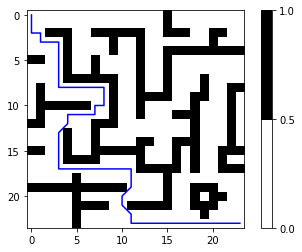

In [166]:
# number of simulations
n_sim = 20
# number of generations
n_gen = 100
# population size
p = 100

# store the best individual of all simulations
best_ind_list = []
ultra_best_ind = Path(n, occ)
# store the average validity of the best individual at each step
avg_validity = np.zeros(n_gen)
# store the average length of the best individual at each step
avg_length = np.zeros(n_gen)

valid_count = 0
for k in range(n_sim):
    print(k)
    gen_alg = RandomAlgorithm(occ, p)
    
    # store the validity of the best individual at each step
    validity = np.zeros(n_gen)
    # store the length of the best individual at each step
    length = np.zeros(n_gen)
    
    for i in range(n_gen):
        best_ind = gen_alg.step()
        valid = best_ind.pb[0] and best_ind.pb[1] and best_ind.pb[2]
        
        validity[i] = valid
        length[i] = best_ind.n_cell

    best_ind_list.append(best_ind)

    if gen_alg.fitness(ultra_best_ind) < gen_alg.fitness(best_ind):
        ultra_best_ind = best_ind
    
    avg_validity += validity
    
    if valid:
        valid_count += 1
        avg_length += length

avg_validity = 1/n_sim * avg_validity
avg_length = 1/valid_count * avg_length

ultra_best_ind.plot()


### Simulation Results

Text(0.5,1,'Evolution of the objective value per number of generations')

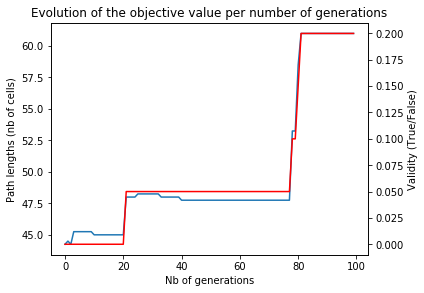

In [169]:
# Plot the results

fig, ax1 = plt.subplots()
ax1.plot(range(n_gen), avg_length)
ax1.set_xlabel('Nb of generations')
ax1.set_ylabel('Path lengths (nb of cells)')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(range(n_gen), avg_validity, color='red')
ax2.set_ylabel('Validity (True/False)')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.legend()
plt.title('Evolution of the objective value per number of generations')
